## Abstract

This blog post analyzes fairness in loan approval processes. I first make a model given the training data and use the coefficents to create a score. I compare that score to a threshold to deterimine if the bank should or should not make the loan based on the training attributes. I find an average bank profit of 1820 after testing out different training features. Despite this being the optimal value, we find that the bank is likely to discriminate against people requesting medical loans, and people with lower incomes. Although these were not explicit features in the model, the model still learned that loaning to the above groups generated more risk that the bank wasn't willing to take on.

## Setup

In [1]:
import pandas as pd
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)
df_train["loan_int_rate"]= (df_train["loan_int_rate"])/100 #making the loan rate into a percentage
df_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,0.0991,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,0.1347,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,0.0751,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,0.1287,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,0.0963,0,0.28,N,10


In this chunk, I set up the data, reset the interest rate so it's a percentage out of 100 and view it.

## Explore

In [2]:
# data display setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

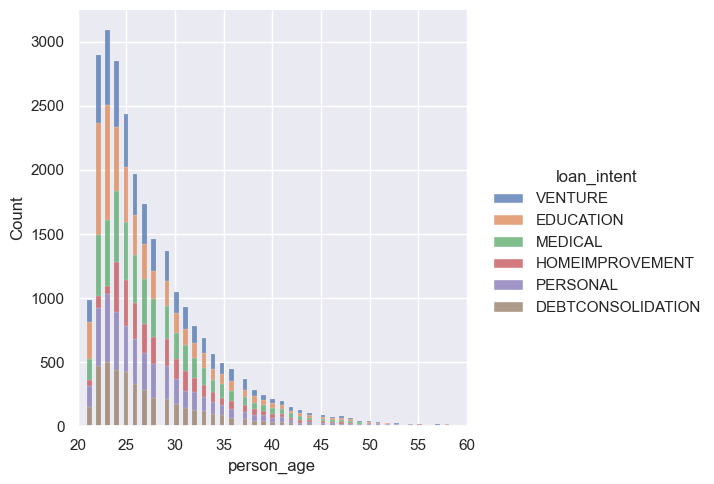

In [3]:

data = df_train

#Creating plot
sns.displot(data=data, x="person_age", hue="loan_intent", multiple="stack")

# Adjusting x-axis limits
plt.xlim(20, 60)

plt.show()

This plot shows the relationship between a person's age and their loan intent. We can see that the most loans are requested by people in their mid-20s, and are mostly for education, with medical aand venture also being top categories. As people get older, they are less likely to want a loan, but the education intent goes down and personal, home improvement and venture loan intents increase.

<Axes: xlabel='person_income', ylabel='loan_int_rate'>

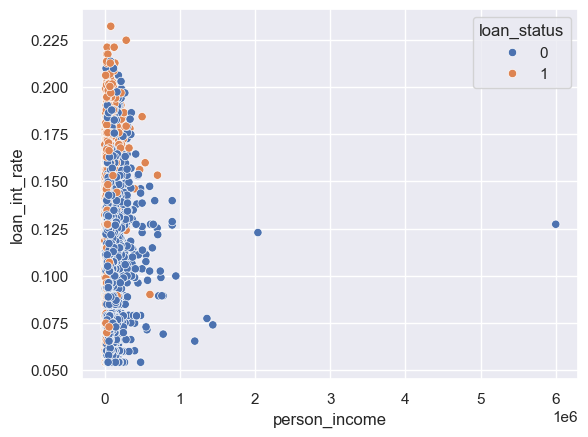

In [4]:
sns.scatterplot(data= data, x= "person_income", y= "loan_int_rate", hue = "loan_status")

From this graph, we can see that the people who get approved for loans often have the highest interest rates, which makes sense from the bank's perspective. A higher interest rate means the bank is making more money, which offsets the risk they take on by offering the loan. On the other hand, It's suprising that people with higher incomes are often not approved for loans. I would expect people with higher income to be more likely to be approved for a loan, given that they have more proof they can pay. A variable that might effect this outcome is the amount they are asking for. It's possible that people with high incomes are asking for large loans that the bank doesn't feel comfortable taking on. 

## Model

In [5]:
#data cleaning
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

#cleaning data
df_train= df_train.dropna()
# econding possible outcome variable
le = LabelEncoder()
df_train["loan_intent"]= le.fit_transform(df_train["loan_intent"]) 


df_train.head()

#df_train["income_for_age"]= df_train["person_emp_length"]+ df_train["cb_person_cred_hist_length"]
cols= ["loan_amnt", "loan_percent_income", "loan_int_rate"]
X_train = df_train[cols]
X_train = StandardScaler().fit_transform(X_train)  # Standardize features
y_train = df_train["loan_status"]

/var/folders/gx/d6zl9l4908q7p_vk4j3x06x00000gn/T/ipykernel_22444/3002538358.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["loan_intent"]= le.fit_transform(df_train["loan_intent"])


I clean the data by dropping NA values and then create a train dataset with target columns, standardize it and then come up with y values.

In [6]:
#modeling
model = LogisticRegression()
model.fit(X_train, y_train)

weights= model.coef_.flatten()
print(weights)


[-0.59390244  1.26796607  1.03233148]


I chose to use logistic regression for this model because the goal is to predict the probability of loan default, which is a binary classification problem. Logistic regression is well-suited for this task as it provides interpretable probability outputs, allowing for clear threshold-based decision-making.

In [7]:
def linear_score(X, w):
  """
  Calculates the linear score between features and weights
  """
  return X@w # or np.dot(X, w)

df_train["score"]= linear_score(X_train, weights)

df_train["score"].head()
print(df_train["score"].max())
print(df_train["score"].min())
print(df_train["score"].mean())


8.291911080319613
-4.45964619067289
3.300377486570684e-16


/var/folders/gx/d6zl9l4908q7p_vk4j3x06x00000gn/T/ipykernel_22444/4082893322.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["score"]= linear_score(X_train, weights)


Here I calculate the linear score between the features (in the columns of X_train) and the weights calculated from the model.

## Find a Threshold

In [8]:
import warnings
warnings.simplefilter("ignore")
                      
import numpy as np
def profit(data, t):
    """
    Calculates the profit the bank makes on a given loan

    Args: 
    data: the dataframe containting the loan requesters
    t: the threshold for accepting a loan

    returns: the updated dataframe with a profit column
    """

    #create binary yes/no values from scores based on t
    y_pred = (data["score"] > t).astype(int)
    data["y_pred"]= y_pred
    data["bank_profit"] = 0.0
    #print(y_pred, y_scores)
    i00 = (data["loan_status"] == 0)& (y_pred == 0)
    i01 = (data["loan_status"] == 0) & (y_pred == 1)
    i10 = (data["loan_status"] == 1) & (y_pred == 0)
    i11 = (data["loan_status"] == 1) &(y_pred == 1)
    #sum up the bank profit based on the predicted values of weather or not someone will default
    data["bank_profit"][i00] = data["loan_amnt"][i00] * (1 + 0.25 * data["loan_int_rate"][i00]) ** 10 - data["loan_amnt"][i00] # best case
    data["bank_profit"][i01] = np.nan
    data["bank_profit"][i10] = data["loan_amnt"][i10] * (1 + 0.25 * data["loan_int_rate"][i10]) ** 3 -1.7 * data["loan_amnt"][i10] # worst case
    data["bank_profit"][i11] = np.nan

    return data


thresholds = np.linspace(-.5, 2, 101)  # Test values between -2 and 2
bank_profits = [profit(df_train, t)["bank_profit"].mean() for t in thresholds] # calculates the average profit per borrower for each t
print(sum(bank_profits))


t_star = thresholds[np.argmax(bank_profits)] #finds the argmax of the bank profits in the bank profit list

print(t_star)

profit(df_train, t_star).head()



168930.56163829993
1823.758481958005
0.050000000000000044


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,score,y_pred,bank_profit
1,27,98000,RENT,3.0,1,C,11750,0.1347,0,0.12,Y,6,-0.008090,0,4613.567568
2,22,36996,RENT,5.0,1,A,10000,0.0751,0,0.27,N,4,0.049639,0,2044.334031
3,24,26000,RENT,2.0,3,C,1325,0.1287,1,0.05,N,4,-0.055660,0,-795.445199
4,29,53004,MORTGAGE,2.0,2,A,15000,0.0963,0,0.28,N,10,0.375078,1,NaN
6,21,21700,RENT,2.0,2,D,5500,0.1491,1,0.25,N,2,2.595504,1,NaN


Here I generate a profit function to calculate the best value that the bank should accept loans at as a threshold value. I do this by creating index markers (i00, i01, i10 and i11) to denote a persons loan status (default or not) and their y_pred, weather or not the bank gives them a loan. I then calculate the profitability using these markers and the equations in class. If a person never recieved a loan, the bank never recieves anything, hence the NaN. I chose to use NaN instead of 0 because it will be easier to calculate the average profit per borrower only including the people who borrowed money. 

I then run the profit function for a range of values using np.linspace to find the optimal value of t where average profit per borrower is the highest.

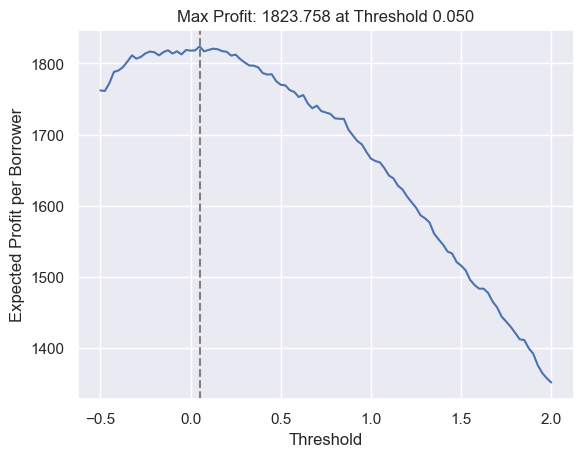

In [9]:
#plotting the graph

thresholds = np.linspace(-.5, 2, 101)
profits = [profit(df_train, t)["bank_profit"].mean() for t in thresholds]

# Find the best threshold
best_threshold = thresholds[np.argmax(profits)]
best_profit = max(profits)

# Plot using Seaborn
sns.lineplot(x=thresholds, y=profits)

# Add vertical line for the best threshold
plt.axvline(best_threshold, linestyle="--", color="gray")

# Labels and title
plt.xlabel("Threshold")
plt.ylabel("Expected Profit per Borrower")
plt.title(f"Max Profit: {best_profit:.3f} at Threshold {best_threshold:.3f}")

plt.show()


Here we see that the optimal value for t= 0.05, with  max profit of $1820 per borrower. We can see a steady climb up to the threshold with increasing values of t and then a sharper droppoff as the bank takes on large sums of risk. An addition to the model would be evaluating the opportunity cost of rejecting a loan with someone who would pay it back to better reflect the downside to being risk-adverse

## Evaluate from the bank's perspective

In [10]:
# Setup for test/clean the testing data
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)
df_test["loan_int_rate"]= (df_test["loan_int_rate"])/100
df_test= df_test.dropna()


In [11]:
X_test= df_test[cols]
X_test = StandardScaler().fit_transform(X_test)
y_test= df_test["loan_status"]
df_test["score"]= linear_score(X_test, weights)
print(t_star)
print(profit(df_test, t_star)["bank_profit"].mean().astype(int))
df_test["score"].head()

0.050000000000000044
1743


0    0.486485
1    0.999932
2   -0.185437
3    0.520230
4    0.731585
Name: score, dtype: float64

I create X and Y test here and run my profit function on it to see what the testing data looks like.

I'm getting a similar average bank profit with the testing data, which makes sense, but at $1615, it is 200 dollars lower than that of the training data. Maybe the characteristics in the training data I used aren't as apparent in the testing data, and maybe different patterns or stronger. It could also be that the testing data has less opporunity for bank income in the first place.

## Evaluate from the borrower's perspective

In [12]:
age_groups = [18, 25, 35, 50, 65, 100]
df_test["age_group"] = pd.cut(df_test["person_age"], bins=age_groups, labels=["18-25", "26-35", "36-50", "51-65", "65+"])
df_test.groupby("age_group")[["y_pred", "loan_status"]].mean().reset_index()

,age_group,y_pred,loan_status
0,18-25,0.490789,0.231024
1,26-35,0.445140,0.216938
2,36-50,0.440767,0.202091
3,51-65,0.487805,0.317073
4,65+,0.600000,0.200000


Younger people are less likley to recieve loans, and they are also the second most likely group to default on their loans. Surpisingly, people aged 51-65 are more likely to recieve loans, but also the most likely to default on them. Given their age, I would assume that they get the benefit of the doubt and are given loans more frequently.

In [13]:
df_test.groupby("loan_intent")[["y_pred", "loan_status"]].mean().reset_index()

,loan_intent,y_pred,loan_status
0,DEBTCONSOLIDATION,0.461283,0.287611
1,EDUCATION,0.476190,0.167517
2,HOMEIMPROVEMENT,0.435065,0.250000
3,MEDICAL,0.486486,0.284250
4,PERSONAL,0.470942,0.220441
5,VENTURE,0.454357,0.146266


Medical loans aren't super likely to given, probably because they have a higher default rate of 28%. Venture and education are most likely to be given, and both have low default rates. This is probably because both loans are seen as an investment into future great economic opportunity.

In [14]:
income_bins = [0, 30000, 60000, 100000, np.inf]
income_labels = ["<30K", "30K-60K", "60K-100K", "100K+"]
df_test["income_group"] = pd.cut(df_test["person_income"], bins=income_bins, labels=income_labels)

df_test.groupby("income_group")[["y_pred", "loan_status"]].mean().reset_index()

,income_group,y_pred,loan_status
0,<30K,0.771242,0.460131
1,30K-60K,0.557899,0.242340
2,60K-100K,0.342538,0.136898
3,100K+,0.133156,0.110519


As income increases, people are more likely to be approved for loans and less likely to default. This makes sense, as people with greater income have more stability, and are more likely to have the capital to pay off a loan, even if their purpose in getting it didn't pay off.

## Discussion

Fairness means that people are given just treatment without discrimination or bias. Therefore, this blog post analyzes questions of fairness by looking at what makes someone elligible for a loan. One of the results was that people requesting medical loans are more likely to default, thereby reducing their chances of recieving the loan. I think that this is unfair, but not from the bank's perspecitive. As a player in a capitalist society, the bank's responsibility is to increase profit for their shareholders. Giving out loans with higher risk of default shouldn't be their responsibility, as it wouldn't be fair to let the bank take the responsibility for high costs of medical care. I think that the burden of responsibility lies with the government. Healthcare shouldn't be a for-profit industry, as profitability and health goals often do not align. Instead, what would be fair is if the government offered more healthcare benefits so people who needed medical procedures wouldn't have to take out a loan. 